In [126]:
import numpy as np
import matplotlib.pyplot as plt

In [127]:
def scale_image(im,width,height):
    old_size = im.size  # old_size[0] is in (width, height) format
    
    if(old_size[0]>width):
        im = im.resize((width,old_size[1]))
        old_size = im.size
        
    if(old_size[1]>height):
        im = im.resize((old_size[0],height))
        old_size = im.size 
    
    delta_w = width - old_size[0]
    delta_h = height - old_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = ImageOps.expand(im, padding,fill=(255,255,255))
    return new_im.convert('L')

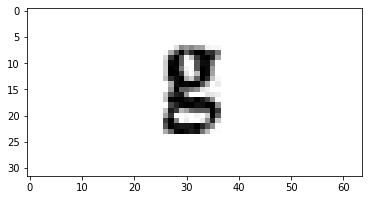

In [128]:
#AS NUMPY
from PIL import Image, ImageOps
from numpy import asarray

scale = (64,32)

im = Image.open('data/1_18-96.png')#.convert('L').resize(scale)

im = Image.open('data/1_77-601.png')#.convert('L').resize(scale)

new_im=scale_image(im,64,32)
#new_im.show()

data = asarray(new_im)

plt.imshow(data,cmap='gray')
plt.show()

# Plot sizes
size file generated with command:
for entry in $(ls); do wc -c "$entry" | awk -F ' ' '{print $1}' >> image_sizes.dat; done

[406 606 171 ... 428 450 448]


3971

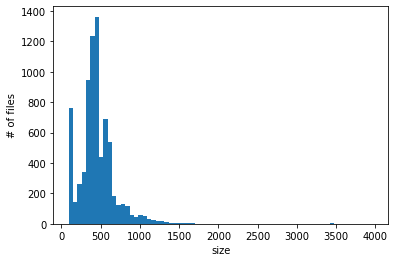

In [129]:
b = []
with open('image_sizes.dat') as infile:
    lines = infile.readlines()
    for line in lines:
        b.append(int(line.strip()))

sizes = np.array(b)
print(sizes)

plt.hist(sizes, bins=70)
plt.ylabel('# of files')
plt.xlabel('size');
np.max(sizes)

In [130]:
from sklearn.model_selection import train_test_split
import glob
from sklearn.decomposition import PCA

images = []
files = list(glob.iglob("data/*"))

for f in files:
    im = Image.open(f)
    im = scale_image(im,64,32)
    img = np.asarray(im)
    images.append(np.reshape(img,64*32))

images = np.array(images)

X_train, X_test, train_names, test_names = train_test_split(images,files_addr,test_size=0.05, random_state=42)
print("TRAIN: ",X_train.shape)
print("TEST: ",X_test.shape)

pca = PCA(n_components=2, whiten=False)
data = pca.fit_transform(X_train)

TRAIN:  (7237, 2048)
TEST:  (381, 2048)


# MODEL

In [131]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

db = DBSCAN(eps=26, min_samples=5,n_jobs=-1).fit(data)

#db = KMeans(init=pca.components_, n_clusters=60, n_init=1)
#db.fit(X_train)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 43
Estimated number of noise points: 881


In [132]:
pred = db.fit_predict(pca.transform(X_test))
classes = np.unique(pred)
d = dict.fromkeys(classes, [])#dictionary with classes as key
for i in range(len(pred)):
    d[pred[i]].append(test_names[i].split("/")[-1:][0])

In [133]:
from jinja2 import Template
t = Template("<h1>CLUSTER</h1><br>{% for clase in cluster %}{% for imag in cluster[clase] %}<li><img src='data/{{ imag }}'>{{ imag }}</li>{% endfor %}<hr>{% endfor %}")
html = t.render(cluster=d)
with open("cluster.html", 'w') as out:
    out.write(html)
